# Customer Segmentation with Clustering

The information is provided in the document `CUSTOMER_DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
%matplotlib inline

### Preprocessing

In [2]:
df = pd.read_csv("CUSTOMER_DATA.csv")
print(df.shape)
count=0
for i in df.columns:
    print('The {} column has {} null values'.format(i, df[i].isna().sum()))

(8068, 10)
The ID column has 0 null values
The Gender column has 0 null values
The Ever_Married column has 140 null values
The Age column has 0 null values
The Graduated column has 78 null values
The Profession column has 0 null values
The Work_Experience column has 829 null values
The Spending_Score column has 0 null values
The Family_Size column has 335 null values
The Var_1 column has 76 null values


In [3]:
# Using median value to replace null values in Work_Experience and Family_Size
# For other columns with null values, use most frequent level in column for replacement

df['Work_Experience'] = df['Work_Experience'].fillna(df['Work_Experience'].median())
df['Family_Size'] = df['Family_Size'].fillna(df['Family_Size'].median())

df = df.fillna(df['Ever_Married'].value_counts().index[0])
df = df.fillna(df['Graduated'].value_counts().index[0])
df = df.fillna(df['Var_1'].value_counts().index[0])

df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Other,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6


In [4]:
# Convert all categorical features

ohe = preprocessing.OneHotEncoder(drop='first')
df_encoded = ohe.fit_transform(df[['Gender', 'Ever_Married', 'Graduated', 'Profession', 
                                   'Spending_Score', 'Var_1']]).toarray()

feature_names = ohe.get_feature_names_out(['Gender', 'Ever_Married', 'Graduated', 'Profession', 
                                   'Spending_Score', 'Var_1'])

df_cat = pd.DataFrame(df_encoded, columns = feature_names)
df_num = pd.DataFrame(df[['ID', 'Age', 'Work_Experience', 'Family_Size']])

dfe = df_num.join(df_cat)

dfe.head(10) 

,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Other,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_Yes
0,462809,22,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,462643,38,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,466315,67,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,461735,67,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,462669,40,1.0,6.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,461319,56,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,460156,32,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,464347,33,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,465015,61,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,465176,55,1.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# Standardize

dfe.drop('ID', axis=1, inplace=True)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfe)
df_scaled = pd.DataFrame(df_scaled, columns=dfe.columns)

### Clustering method #1: using K-means method

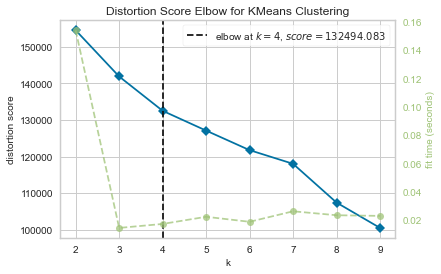

In [6]:
KClusterer = KMeans(random_state=9, n_init='auto')

visualizer = KElbowVisualizer(KClusterer, 
                             k=(2,10),
                             locate_elbow=True,
                             timings=True,
                             random_state=9)   


visualizer.fit(df_scaled)       
visualizer.show();

Using elbow method, optimal number of clusters is 4.

In [9]:
# Reporting silhouette scores for K-means analysis to compare

for n in [2,3,4,5,6,7,8]:
    KClusterer = KMeans(n_clusters=n, random_state=9, n_init='auto')
    df_scaled['cluster_label'] = KClusterer.fit_predict(df_scaled)
    sil = (silhouette_score(df_scaled, df_scaled['cluster_label'], random_state=9)).round(3)
    print('The silhouette score with {} clusters is {}'.format(n, sil))

The silhouette score with 2 clusters is 0.09
The silhouette score with 3 clusters is 0.118
The silhouette score with 4 clusters is 0.151
The silhouette score with 5 clusters is 0.188
The silhouette score with 6 clusters is 0.177
The silhouette score with 7 clusters is 0.262
The silhouette score with 8 clusters is 0.206


Using the silhouette scores, optimal number of clusters is 7.

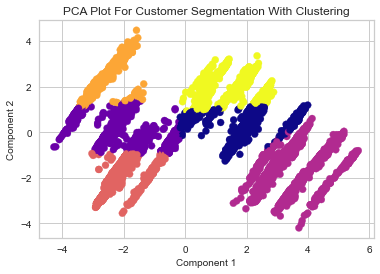

In [10]:
# Performing dimension reduction with PCA using 2 components

pca = PCA(n_components=2, random_state=9)
Xpca = pca.fit_transform(df_scaled)

x = Xpca[:,0]
y = Xpca[:,1]


KClusterer = KMeans(n_clusters=6, random_state=9, n_init='auto')
clusters = KClusterer.fit_predict(Xpca)

# Draw scatter plot where points are differentiated by clusters

plt.scatter(x, y, c=clusters, cmap='plasma')
plt.title('PCA Plot For Customer Segmentation With Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show();

In [11]:
# Using 4 clusters, analyzing characteristics of each cluster

KClusterer = KMeans(n_clusters=4, random_state=9, n_init='auto')

dfe['cluster_label'] = KClusterer.fit_predict(dfe)

groups = dfe.groupby('cluster_label')

avgs_table = groups.mean()

print(avgs_table)

                     Age  Work_Experience  Family_Size  Gender_Male  \
cluster_label                                                         
0              26.561827         2.836242     3.434088     0.535091   
1              54.829914         1.783477     2.800216     0.583153   
2              40.380366         3.122019     2.592210     0.522258   
3              75.489573         1.147964     2.074479     0.577954   

               Ever_Married_Yes  Graduated_Yes  Profession_Doctor  \
cluster_label                                                       
0                      0.196064       0.382844           0.126625   
1                      0.876350       0.792117           0.061555   
2                      0.664944       0.763514           0.083466   
3                      0.952334       0.622642           0.022840   

               Profession_Engineer  Profession_Entertainment  \
cluster_label                                                  
0                         0.07

#### Analysis:
Cluster 0 seems to be made up of younger, unmarried customers who could still be students. Of those who are working, many of them are in healthcare and they have the lowest spending power. Cluster 1 is made up of older/middle-aged customers who might have families and this group has the most males and most graduates. Cluster 2 might be made up of young professionals as they have a slightly lower average age compared to Cluster 1, smaller families, and more work experience. Cluster 3 are the oldest group and they have the most buying power compared to other clusters. These customers may be entering retirement or already be retired. Most are married but have the smallest families.

### Clustering method #2: Agglomerative clustering

In [13]:
# Perform dimension reduction with PCA using 4 components

pca = PCA(n_components=4, random_state=9)
Xpca = pca.fit_transform(df_scaled)

# Looking for best number of clusters through silhouette analysis

for n in [3,4,5,6,7,8]:
    agClusterer = AgglomerativeClustering(n_clusters=n, metric='cosine', linkage='average')
    df_scaled['cluster_label'] = agClusterer.fit_predict(Xpca)
    sil = (silhouette_score(Xpca, df_scaled['cluster_label'], random_state=9)).round(3)
    print('The silhouette score with {} clusters is {}'.format(n, sil))

The silhouette score with 3 clusters is 0.316
The silhouette score with 4 clusters is 0.417
The silhouette score with 5 clusters is 0.404
The silhouette score with 6 clusters is 0.249
The silhouette score with 7 clusters is 0.246
The silhouette score with 8 clusters is 0.31


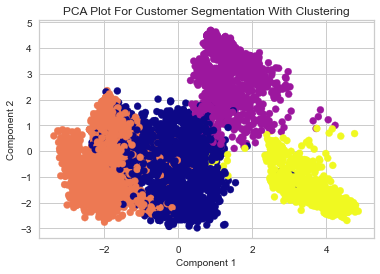

In [14]:
# Using optimal number of clusters (4) to graph the scatter plot of the PCA-transformed data differentiated by cluster

agClusterer = AgglomerativeClustering(n_clusters=4, metric='cosine', linkage='average')
clusters = agClusterer.fit_predict(Xpca)

x = Xpca[:,0]
y = Xpca[:,1]

plt.scatter(x, y, c=clusters, cmap='plasma')
plt.title('PCA Plot For Customer Segmentation With Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show();

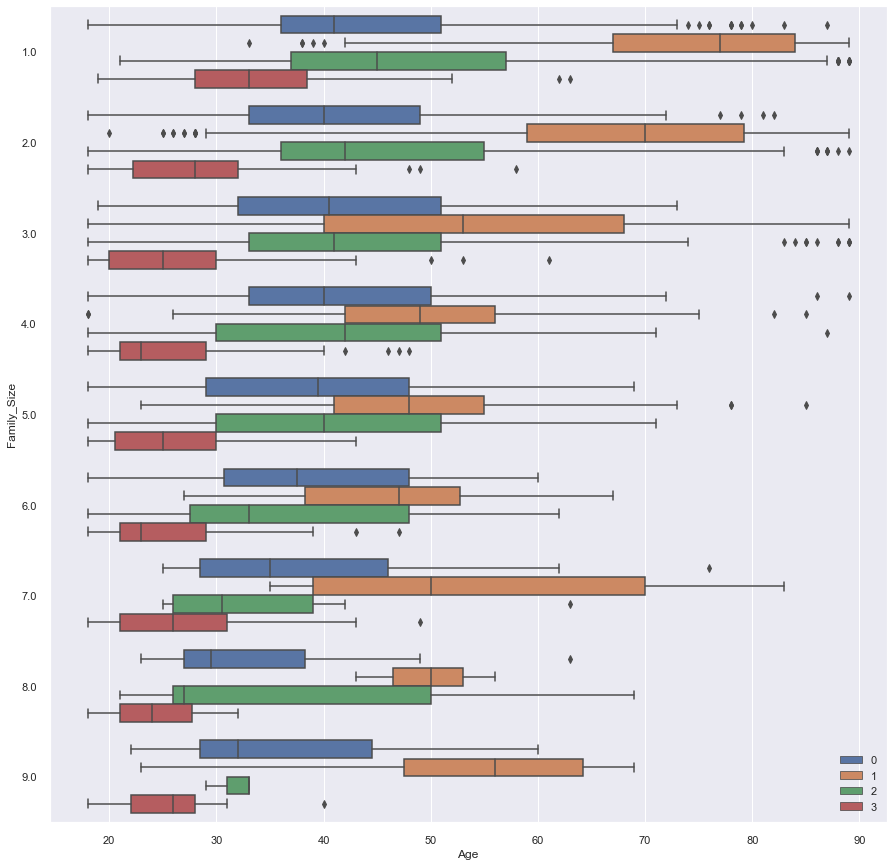

In [16]:
# Showing differences among clusters using boxplot of Age vs Family_size

sns.boxplot(x=dfe['Age'], y=dfe['Family_Size'], hue=clusters, orient='h')
sns.set(rc={'figure.figsize':(20,20)});

In [17]:
# Create a table of averages per variable to analyze characteristics of each cluster

groups = dfe.groupby(clusters)

avgs_table = groups.mean()

print(avgs_table)

         Age  Work_Experience  Family_Size  Gender_Male  Ever_Married_Yes  \
0  41.727820         2.286717     3.008521     0.473684          0.652632   
1  59.412778         1.861450     2.898062     0.663317          0.992821   
2  44.930317         2.893213     2.369834     0.534842          0.601508   
3  26.181685         2.348718     3.772894     0.567766          0.076190   

   Graduated_Yes  Profession_Doctor  Profession_Engineer  \
0       0.584962           0.136341             0.242105   
1       0.616655           0.012204             0.001436   
2       0.781297           0.120362             0.063650   
3       0.315018           0.000000             0.002198   

   Profession_Entertainment  Profession_Healthcare  ...  Spending_Score_High  \
0                  0.181955               0.015539  ...             0.059148   
1                  0.017947               0.025844  ...             0.770280   
2                  0.167421               0.009955  ...             0.006

Cluster 0 is comprised of older, mostly male, mostly married customers. These are the highest spenders and most are graduated. Cluster 1 is similar in age but slightly younger on average compared to Cluster 0 and this group is almost completely female. They have the most work experience and are the most educated group. Cluster 2 is the youngest group with the least educated and lowest spending. These people may still be living at home since they have much larger families on average despite majority being unmarried.